# Evaluation Notebook

**Loading Imports**

In [1]:
import os
import pandas as pd
import torch
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import zipfile
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc,
    brier_score_loss
)

In [2]:
# Loading Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Writing Directory Variables, Creating Data Classes, Creating DataLoaders, and Unzipping Data**

In [3]:
# ------------------------------- !!!!!!!!!!!!
# UNZIPPING CHEXPERT BINARY DATA (REPLACE ZIP PATH WITH YOUR OWN DIRECTORY AND FILE NAMES)
# ------------------------------- !!!!!!!!!!!!
zip_path = "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/binary_test.zip"
extract_dir = "/tmp/CheXpert_binary/"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping CheXpert Binary"):
        z.extract(f, extract_dir)

# ------------------------------- !!!!!!!!!!!!
# SETTING CHEXPERT BINARY CSV AND TEST IMAGE PATHS (REPLACE PATHS WITH YOUR OWN DIRECTORY AND FILE NAMES)
# ------------------------------- !!!!!!!!!!!!
CHEXPERT_BINARY_IMAGES = "/tmp/CheXpert_binary/test/"
CHEXPERT_BINARY_CSV = "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/0_final_project_updated_names_test_transfer_binary.csv"


# ------------------------------- !!!!!!!!!!!!
# UNZIPPING CHEXPERT MULTICLASS DATA (REPLACE ZIP PATH WITH YOUR OWN DIRECTORY AND FILE NAMES)
# ------------------------------- !!!!!!!!!!!!
zip_path = "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/mutliclass_test.zip"
extract_dir = "/tmp/CheXpert_multiclass/"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping CheXpert Multiclass"):
        z.extract(f, extract_dir)

# ------------------------------- !!!!!!!!!!!!
# SETTING CHEXPERT MULTICLASS CSV AND TEST IMAGE PATHS (REPLACE PATHS WITH YOUR OWN DIRECTORY AND FILE NAMES)
# ------------------------------- !!!!!!!!!!!!
CHEXPERT_MULTICLASS_IMAGES = "/tmp/CheXpert_multiclass/test/"
CHEXPERT_MULTICLASS_CSV = "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/3_final_project_updated_names_test_transfer.csv"

# ------------------------------- !!!!!!!!!!!!
# UNZIPPING NIH DATA (REPLACE ZIP PATH WITH YOUR OWN DIRECTORY AND FILE NAMES)
# ------------------------------- !!!!!!!!!!!!
zip_path = "/content/drive/MyDrive/Project_Eval/Datasets/NIH/test.zip"
extract_dir = "/tmp/NIH/"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping NIH"):
        z.extract(f, extract_dir)

# ------------------------------ !!!!!!!!!!!!
# SETTING NIH CSV AND TEST IMAGE PATHS (REPLACE PATHS WITH YOUR OWN DIRECTORY AND FILE NAMES)
# ------------------------------- !!!!!!!!!!!!
NIH_TEST_IMAGES = "/tmp/NIH/test/"
NIH_TEST_CSV = "/content/drive/MyDrive/Project_Eval/Datasets/NIH/nih_test.csv"


Unzipping NIH: 100%|██████████| 583/583 [00:00<00:00, 1033.94it/s]


In [ ]:
# ------------------------------ !!!!!!!!!!!!
# SETTING MODEL PATHS (REPLACE PATHS WITH YOUR OWN DIRECTORY AND FILE NAMES)
# ------------------------------- !!!!!!!!!!!!
CHEXPERT_BINARY_MODEL_PATH = "/content/drive/MyDrive/Project_Eval/Models/CheXpert_Pneumonia_binary_resnet50_finetuned_model.pth"
CHEXPERT_MULTICLASS_MODEL_PATH = "/content/drive/MyDrive/Project_Eval/Models/CheXpert_Multiclass_resnet50_finetuned_model.pth"
NIH_MODEL_PATH = "/content/drive/MyDrive/Project_Eval/Models/NIH_resnet50_finetuned_model.pth"

In [48]:
# Writing classes for each dataset.
# I added Key Errors to ensure that the class would catch any incorrect dataset mismatches (during the dataload)
class CheXpertBinaryDataset(Dataset):
    def __init__(self, df, img_root, transform=None):
        self.df = df
        self.img_root = img_root
        self.transform = transform

        if "path" in df.columns:
            self.path_col = "path"
        else:
            self.path_col = "Path"

        self.label_col = "Pneumonia"
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = os.path.join(self.img_root, row[self.path_col])
        image = Image.open(image_path).convert("RGB")

        label = float(row[self.label_col])

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


class CheXpertMulticlassDataset(Dataset):
    def __init__(self, df, img_root, transform=None):
        self.df = df
        self.img_root = img_root
        self.transform = transform

        if "path" in df.columns:
            self.path_col = "path"
        else:
            self.path_col = "Path"

        self.label_col = "label"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = os.path.join(self.img_root, row[self.path_col])
        image = Image.open(image_path).convert("RGB")

        label = int(row[self.label_col])

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


class NIHBinaryDataset(Dataset):
    def __init__(self, df, img_root, transform=None):
        self.df = df
        self.img_root = img_root
        self.transform = transform

        if "Path" in df.columns:
            self.path_col = "Path"
        elif "path" in df.columns:
            self.path_col = "path"
        else:
            raise KeyError(f"No valid image path column found in NIH CSV. Columns = {df.columns}")

        if "Pneumonia" in df.columns:
            self.label_col = "Pneumonia"
        else:
            raise KeyError(f"No 'Pneumonia' label column found. Columns = {df.columns}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.img_root, row[self.path_col])
        image = Image.open(img_path).convert("RGB")

        label = float(row[self.label_col])

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


In [5]:
# Added tensor transformer for the test data
test_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
])

In [49]:
# Loading local dataframes from csv data
chex_bin_df   = pd.read_csv(CHEXPERT_BINARY_CSV)
chex_multi_df = pd.read_csv(CHEXPERT_MULTICLASS_CSV)
nih_df = pd.read_csv(NIH_TEST_CSV)

# Instantiating Dataset classes
chex_bin_dataset = CheXpertBinaryDataset(
    df=chex_bin_df,
    img_root=CHEXPERT_BINARY_IMAGES,
    transform=test_transform
)

chex_multi_dataset = CheXpertMulticlassDataset(
    df=chex_multi_df,
    img_root=CHEXPERT_MULTICLASS_IMAGES,
    transform=test_transform
)

nih_dataset = NIHBinaryDataset(
    nih_df,
    NIH_TEST_IMAGES,
    transform=test_transform
)

# Instantiating Dataloaders
chex_bin_loader = DataLoader(chex_bin_dataset, batch_size=32, shuffle=False)
chex_multi_loader = DataLoader(chex_multi_dataset, batch_size=32, shuffle=False)
nih_loader = DataLoader(nih_dataset, batch_size=32, shuffle=False)

**Model Building and Loading**

In [8]:
# Loading base resnet50 without weights
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, 1)

In [9]:
# Defining build functions for each model
def build_resnet50_binary_2class():
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

def build_resnet50_multiclass():
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 14)
    return model

def build_resnet50_nih_3class():
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 3)
    return model

def load_from_checkpoint(model, path):
    ckpt = torch.load(path, map_location="cuda")
    state_dict = ckpt["model_state"]
    model.load_state_dict(state_dict)
    model = model.cuda()
    model.eval()
    return model

In [10]:
# Loading Chexpert Binary Model
model_chex_binary = build_resnet50_binary_2class()
model_chex_binary = load_from_checkpoint(model_chex_binary, CHEXPERT_BINARY_MODEL_PATH)
print("Loaded CheXpert Binary model")

Loaded CheXpert Binary model


In [12]:
# Loading NIH Model
model_nih = build_resnet50_nih_3class()
model_nih = load_from_checkpoint(model_nih, NIH_MODEL_PATH)
print("Loaded NIH 3-Class model")

Loaded NIH 3-Class model


In [50]:
# Loading Chexpert Multiclass Model
model_chex_multi = build_resnet50_multiclass()
model_chex_multi = load_from_checkpoint(model_chex_multi, CHEXPERT_MULTICLASS_MODEL_PATH)
print("Loaded CheXpert Multiclass model")

Loaded CheXpert Multiclass model


**Evaluation Helpers**

In [15]:
# Getting predictions from the model (binary or multi-label)
def get_predictions(model, dataloader, task):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda()

            logits = model(imgs)

            if task == "binary":
                probs = torch.sigmoid(logits.squeeze())
            elif task == "multiclass":
                probs = torch.softmax(logits, dim=1)
            else:
                raise ValueError("Unknown task")

            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_labels), torch.cat(all_probs)

In [16]:
def extract_positive_class(probs, labels, positive_class=1):
    if probs.ndim == 2 and probs.shape[1] > 1:
        pos_probs = probs[:, positive_class]
    else:
        pos_probs = probs.squeeze()

    return pos_probs.numpy(), labels.numpy()

In [17]:
# Computing ROC curve and ROC AUC
def compute_roc_auc(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    return fpr, tpr, roc_auc


In [18]:
# def plot_roc_curve(fpr, tpr, roc_auc, title):
#     plt.figure(figsize=(6,6))
#     plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
#     plt.plot([0,1],[0,1],'--', color="gray")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title(f"ROC Curve\n{title}")
#     plt.legend()
#     plt.show()

In [19]:
# Computing PR curve and PR AUC
def compute_pr_auc(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    return precision, recall, pr_auc


In [20]:
# # Plotting PR curve
# def plot_pr_curve(precision, recall, pr_auc):
#     plt.figure(figsize=(6,6))
#     plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
#     plt.xlabel("Recall")
#     plt.ylabel("Precision")
#     plt.title("Precision–Recall Curve")
#     plt.legend()
#     plt.show()


In [21]:
# Computing Brier score (calibration loss)
def compute_brier_score(y_true, y_prob):
    return brier_score_loss(y_true, y_prob)


In [22]:
# Computing Expected Calibration Error
def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        start = bins[i]
        end = bins[i+1]

        mask = (y_prob >= start) & (y_prob < end)
        if mask.sum() == 0:
            continue

        bin_acc = y_true[mask].mean()
        bin_conf = y_prob[mask].mean()

        ece += mask.mean() * abs(bin_conf - bin_acc)

    return ece


In [36]:
# # Plotting calibration (reliability) curve
# def plot_calibration_curve(y_true, y_prob, title):
#     plt.figure(figsize=(6,6))
#     bins = np.linspace(0,1,11)
#     true_centers = []
#     pred_centers = []

#     for i in range(len(bins)-1):
#         idx = (y_prob >= bins[i]) & (y_prob < bins[i+1])
#         if idx.sum() > 0:
#             true_centers.append(y_true[idx].mean())
#             pred_centers.append(y_prob[idx].mean())

#     plt.plot(pred_centers, true_centers, marker='o')
#     plt.plot([0,1],[0,1],'--', color='gray')
#     plt.xlabel("Predicted Probability")
#     plt.ylabel("True Frequency")
#     plt.title(f"Calibration Curve\n{title}")
#     plt.show()

In [38]:
def evaluate_all_metrics(y_true, y_prob, title_suffix=""):
    # === Compute metrics ===
    fpr, tpr, roc_auc = compute_roc_auc(y_true, y_prob)
    precision, recall, pr_auc = compute_pr_auc(y_true, y_prob)
    brier = compute_brier_score(y_true, y_prob)
    ece = compute_ece(y_true, y_prob)

    # === Print ===
    print("===== METRICS =====")
    print("ROC AUC:", roc_auc)
    print("PR AUC:", pr_auc)
    print("Brier Score:", brier)
    print("ECE:", ece)
    print()

    # Plotting ROC Curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve\n{title_suffix}")
    plt.legend()
    plt.show()

    # Plotting PR Curve
    plt.figure(figsize=(6,6))
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve\n{title_suffix}")
    plt.legend()
    plt.show()

    # Plotting Calibration Curve
    bins = np.linspace(0,1,11)
    true_centers, pred_centers = [], []
    for i in range(len(bins)-1):
        idx = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if idx.sum() > 0:
            true_centers.append(y_true[idx].mean())
            pred_centers.append(y_prob[idx].mean())

    plt.figure(figsize=(6,6))
    plt.plot(pred_centers, true_centers, marker='o')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Frequency")
    plt.title(f"Calibration Curve\n{title_suffix}")
    plt.show()

    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "brier": brier,
        "ece": ece
    }


**Evaluation**

===== METRICS =====
ROC AUC: 0.5502760330578513
PR AUC: 0.60048899723789
Brier Score: 0.3284791856380421
ECE: 0.28719672835790194



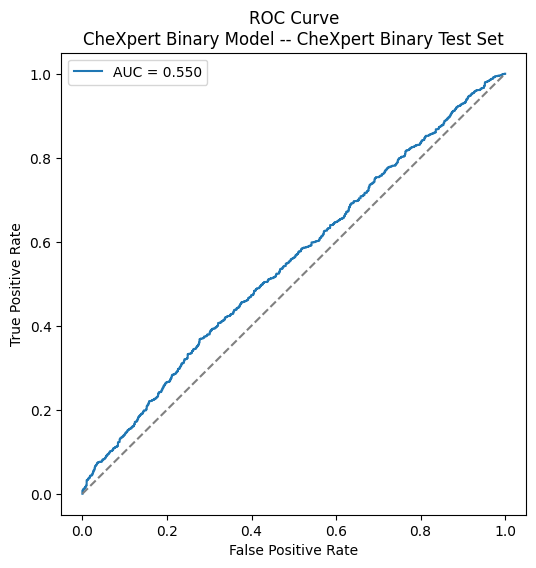

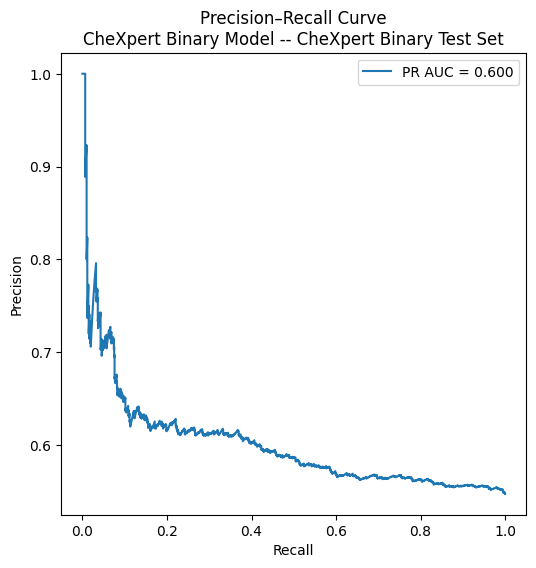

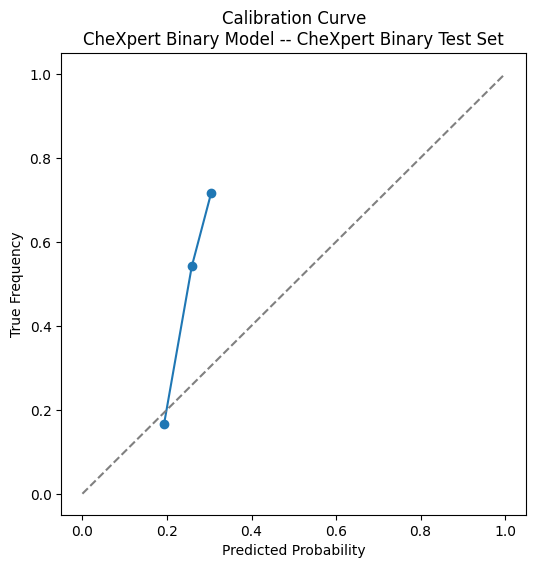

{'roc_auc': np.float64(0.5502760330578513),
 'pr_auc': np.float64(0.60048899723789),
 'brier': np.float64(0.3284791856380421),
 'ece': np.float64(0.28719672835790194)}

In [39]:
# CHEXPERT BINARY MODEL TO CHEXPERT TEST SET
# ------------------------------------------

# Running model on test loader
bin_labels, bin_probs = get_predictions(
    model_chex_binary,
    chex_bin_loader,
    task="binary")

# Extracting probability of pneumonia
pos_probs, pos_labels = extract_positive_class(
    bin_probs,
    bin_labels,
    positive_class=1)

# Generating metrics
evaluate_all_metrics(
    pos_labels,
    pos_probs,
    title_suffix="CheXpert Binary Model -- CheXpert Binary Test Set")

===== METRICS =====
ROC AUC: 0.43948677194421654
PR AUC: 0.6128699024872755
Brier Score: 0.3644986069110843
ECE: 0.3545168946015424



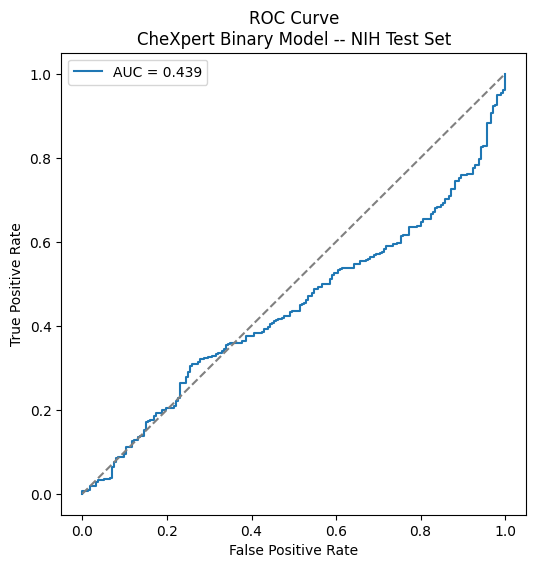

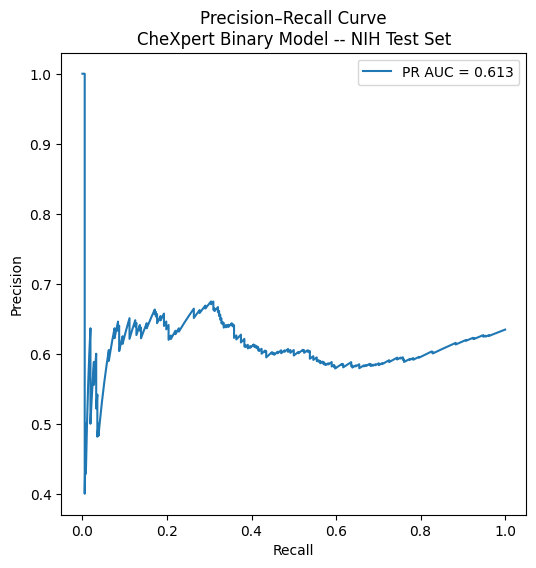

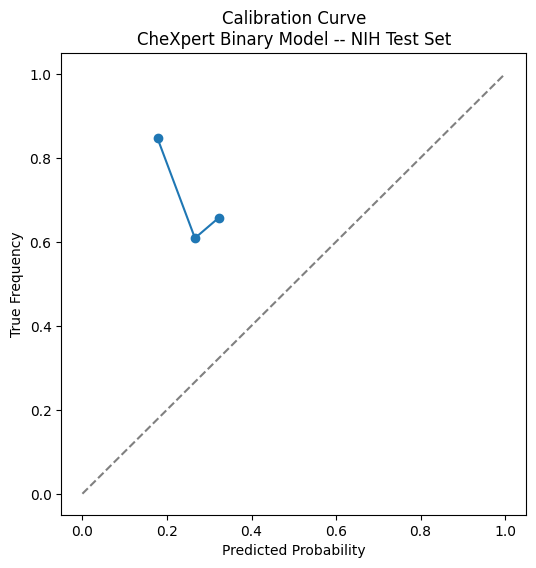

{'roc_auc': np.float64(0.43948677194421654),
 'pr_auc': np.float64(0.6128699024872755),
 'brier': np.float64(0.3644986069110843),
 'ece': np.float64(0.3545168946015424)}

In [45]:
# CHEXPERT BINARY MODEL TO NIH TEST SET
# ------------------------------------------

nih_labels_cd, nih_probs_cd = get_predictions(
    model_chex_binary,
    nih_loader,
    task="binary"
)

nih_pos_probs_cd, nih_pos_labels_cd = extract_positive_class(
    nih_probs_cd,
    nih_labels_cd,
    positive_class=1
)

evaluate_all_metrics(
    nih_pos_labels_cd,
    nih_pos_probs_cd,
    title_suffix="CheXpert Binary Model -- NIH Test Set"
)

===== METRICS =====
ROC AUC: 0.8266765791632487
PR AUC: 0.891445080809173
Brier Score: 0.3394714394687686
ECE: 0.3368714451789856



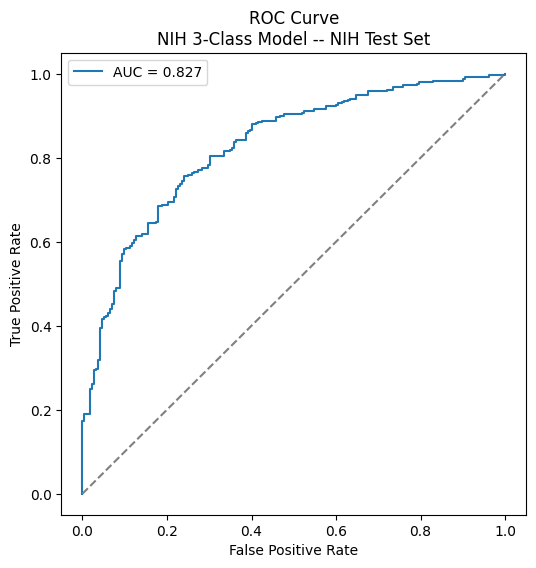

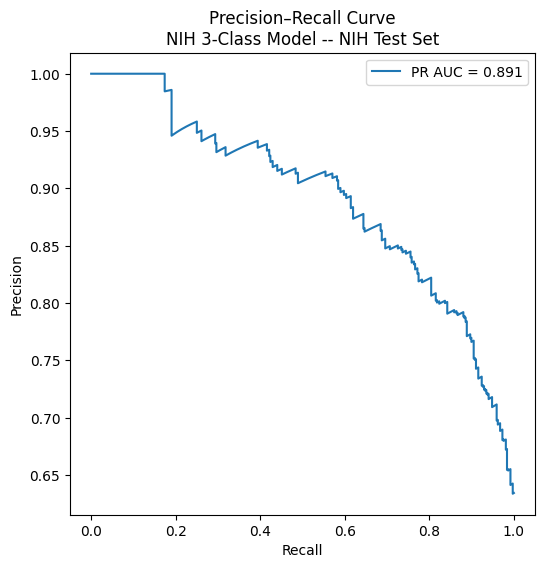

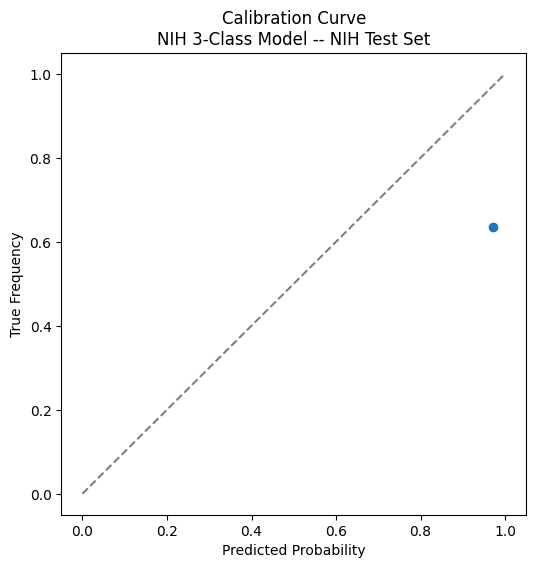

{'roc_auc': np.float64(0.8266765791632487),
 'pr_auc': np.float64(0.891445080809173),
 'brier': np.float64(0.3394714394687686),
 'ece': np.float64(0.3368714451789856)}

In [44]:
# NIH MODEL TO NIH TEST SET
# ------------------------------------------

nih_labels, nih_probs = get_predictions(
    model_nih,
    nih_loader,
    task="binary"
)

nih_pos_probs, nih_pos_labels = extract_positive_class(
    nih_probs,
    nih_labels,
    positive_class=1
)

evaluate_all_metrics(
    nih_pos_labels,
    nih_pos_probs,
    title_suffix="NIH 3-Class Model -- NIH Test Set")

===== METRICS =====
ROC AUC: 0.48498801652892565
PR AUC: 0.5361480491425668
Brier Score: 0.4113500403816752
ECE: 0.4028198994123019



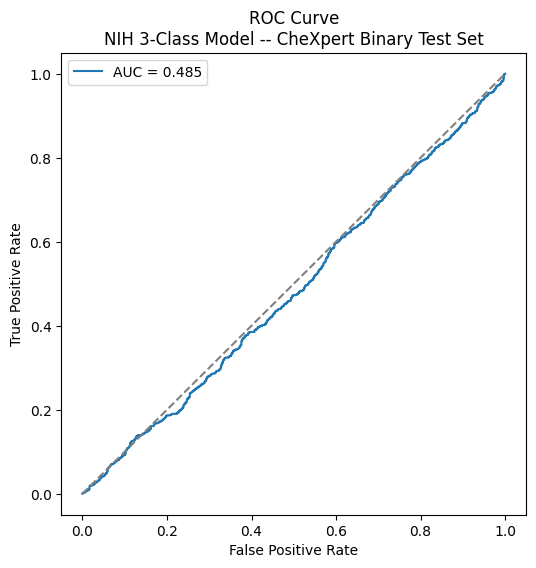

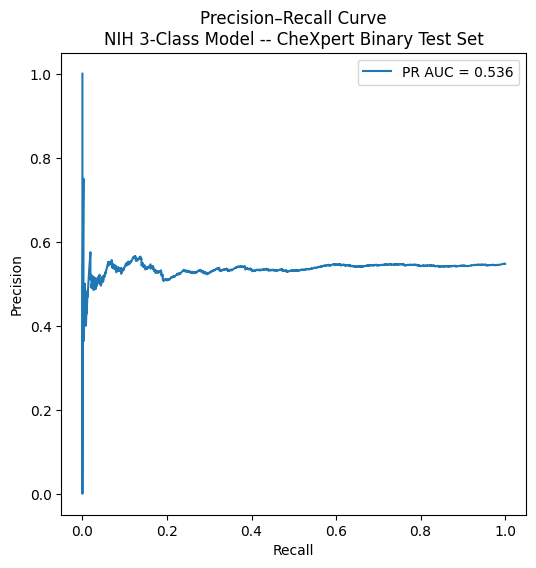

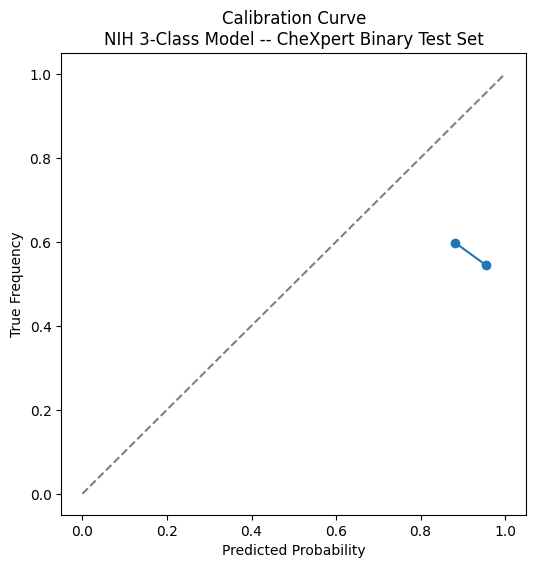

{'roc_auc': np.float64(0.48498801652892565),
 'pr_auc': np.float64(0.5361480491425668),
 'brier': np.float64(0.4113500403816752),
 'ece': np.float64(0.4028198994123019)}

In [46]:
# NIH MODEL TO CHEXPERT TEST SET
# ------------------------------------------

chexbin_labels_cd, chexbin_probs_cd = get_predictions(
    model_nih,
    chex_bin_loader,
    task="binary"
)

chexbin_pos_probs_cd, chexbin_pos_labels_cd = extract_positive_class(
    chexbin_probs_cd,
    chexbin_labels_cd,
    positive_class=1
)

evaluate_all_metrics(
    chexbin_pos_labels_cd,
    chexbin_pos_probs_cd,
    title_suffix="NIH 3-Class Model -- CheXpert Binary Test Set"
)
